In [1]:
import sqlite3
import pandas as pd

In [2]:
db_path = "../news_evaluation/summarize_news.db"
conn = sqlite3.connect(db_path)
table_names = ["cryptobert", "distilroberta_ffnsa", "finbert", "finbert_tone"]
dataframes = {}

for table in table_names:
    query = f"SELECT positive, neutral, negative FROM {table}"
    dataframes[table] = pd.read_sql_query(query, conn)

conn.close()

cryptobert_df = dataframes["cryptobert"]
distilroberta_ffnsa_df = dataframes["distilroberta_ffnsa"]
finbert_df = dataframes["finbert"]
finbert_tone_df = dataframes["finbert_tone"]

In [3]:
cryptobert_df = cryptobert_df.add_prefix("cryptobert_")
distilroberta_ffnsa_df = distilroberta_ffnsa_df.add_prefix("distilroberta_ffnsa_")
finbert_df = finbert_df.add_prefix("finbert_")
finbert_tone_df = finbert_tone_df.add_prefix("finbert_tone_")
# Combine the dataframes into a single dataframe
combined_df = pd.concat([cryptobert_df, distilroberta_ffnsa_df, finbert_df, finbert_tone_df], axis=1)
# Matrices of correlations for "positive", "neutral", and "negative"
positive_positive_corr = combined_df.filter(like="positive").corr()
neutral_neutral_corr = combined_df.filter(like="neutral").corr()
negative_negative_corr = combined_df.filter(like="negative").corr()

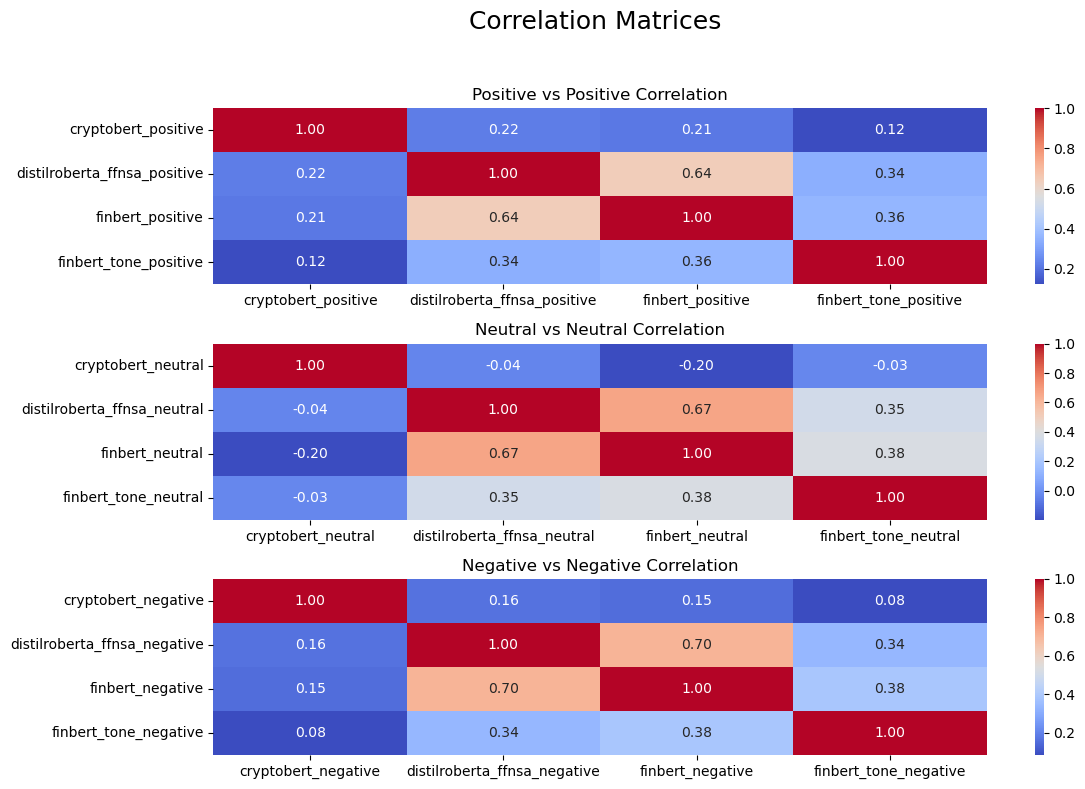

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization of each matrix
plt.figure(figsize=(12, 8))
plt.suptitle("Correlation Matrices", fontsize=18)

# Positive vs Positive
plt.subplot(3, 1, 1)
sns.heatmap(positive_positive_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Positive vs Positive Correlation")

# Neutral vs Neutral
plt.subplot(3, 1, 2)
sns.heatmap(neutral_neutral_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Neutral vs Neutral Correlation")

# Negative vs Negative
plt.subplot(3, 1, 3)
sns.heatmap(negative_negative_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Negative vs Negative Correlation")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Calculate and Print Correlations for All Sentiments

In [12]:
# Positive correlations
positive_mean_correlations = {
    col: positive_positive_corr[col].mean() for col in positive_positive_corr.columns
}
sorted_positive_mean_correlations = dict(sorted(positive_mean_correlations.items(), key=lambda x: x[1], reverse=True))
print("\nAverage correlations for 'positive' across models:")
for model, mean_corr in sorted_positive_mean_correlations.items():
    print(f"{model}: {mean_corr:.4f}")

# Neutral correlations
neutral_neutral_corr = combined_df.filter(like="neutral").corr()
neutral_mean_correlations = {
    col: neutral_neutral_corr[col].mean() for col in neutral_neutral_corr.columns
}
sorted_neutral_mean_correlations = dict(sorted(neutral_mean_correlations.items(), key=lambda x: x[1], reverse=True))
print("\nAverage correlations for 'neutral' across models:")
for model, mean_corr in sorted_neutral_mean_correlations.items():
    print(f"{model}: {mean_corr:.4f}")

# Negative correlations
negative_negative_corr = combined_df.filter(like="negative").corr()
negative_mean_correlations = {
    col: negative_negative_corr[col].mean() for col in negative_negative_corr.columns
}
sorted_negative_mean_correlations = dict(sorted(negative_mean_correlations.items(), key=lambda x: x[1], reverse=True))
print("\nAverage correlations for 'negative' across models:")
for model, mean_corr in sorted_negative_mean_correlations.items():
    print(f"{model}: {mean_corr:.4f}")


Average correlations for 'positive' across models:
finbert_positive: 0.5532
distilroberta_ffnsa_positive: 0.5504
finbert_tone_positive: 0.4548
cryptobert_positive: 0.3885

Average correlations for 'neutral' across models:
distilroberta_ffnsa_neutral: 0.4939
finbert_neutral: 0.4615
finbert_tone_neutral: 0.4232
cryptobert_neutral: 0.1826

Average correlations for 'negative' across models:
finbert_negative: 0.5606
distilroberta_ffnsa_negative: 0.5504
finbert_tone_negative: 0.4509
cryptobert_negative: 0.3502


Variance for all tables

In [10]:
variances = {
    "cryptobert": combined_df.filter(like="cryptobert_").var().mean(),
    "distilroberta_ffnsa": combined_df.filter(like="distilroberta_ffnsa_").var().mean(),
    "finbert": combined_df.filter(like="finbert_").var().mean(),
    "finbert_tone": combined_df.filter(like="finbert_tone_").var().mean(),
}
sorted_variances = dict(sorted(variances.items(), key=lambda x: x[1]))
print("\nAverage variance for each data frame:")
for model, variance in sorted_variances.items():
    print(f"{model}: {variance:.4f}")


Average variance for each data frame:
cryptobert: 0.0321
finbert: 0.1521
finbert_tone: 0.1798
distilroberta_ffnsa: 0.2017


Variance for each sentiment:

In [18]:
# Initialize a dictionary to store results
dispersion_metrics = {"variance": {}, "std_dev": {}}

# List of dataframes and their prefixes
dataframes_with_prefixes = {
    "cryptobert": cryptobert_df,
    "distilroberta_ffnsa": distilroberta_ffnsa_df,
    "finbert": finbert_df,
    "finbert_tone": finbert_tone_df,
}

# Iterate over each dataframe
for model_name, df in dataframes_with_prefixes.items():
    # Initialize metrics for the model
    dispersion_metrics["variance"][model_name] = {}
    dispersion_metrics["std_dev"][model_name] = {}
    
    # Calculate variance and standard deviation for positive, neutral, and negative
    for sentiment in ["positive", "neutral", "negative"]:
        columns = df.filter(like=sentiment).columns
        sentiment_variance = df[columns].var().mean()  # Mean variance across columns
        sentiment_std_dev = df[columns].std().mean()  # Mean std deviation across columns
        
        # Store results
        dispersion_metrics["variance"][model_name][sentiment] = sentiment_variance
        dispersion_metrics["std_dev"][model_name][sentiment] = sentiment_std_dev

# Display results
with open("dispersion_metrics.txt", "w") as file:
    file.write("Dispersion Metrics (Variance and Standard Deviation):\n\n")
    for metric_type, metrics in dispersion_metrics.items():
        file.write(f"{metric_type.capitalize()} by Model and Sentiment:\n")
        for model_name, sentiments in metrics.items():
            file.write(f"  {model_name}:\n")
            for sentiment, value in sentiments.items():
                file.write(f"    {sentiment.capitalize()}: {value:.4f}\n")
            file.write("\n")  # Add a blank line between models
print("Metrics have been saved to dispersion_metrics.txt.")

Metrics have been saved to dispersion_metrics.txt.
